In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier

In [419]:
import modules
import importlib
importlib.reload(modules)

<module 'modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\modules.py'>

In [420]:
bounded_dists = modules.get_bounded_distribution()
bounded_dists

{'arcsine': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ffa2c2f7c0>,
 'beta_1_2': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ffa2c2bf70>,
 'powerlaw_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ffa2c3e070>,
 'trapezoid_0.3_0.8': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ffa2c2b850>,
 'traing_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ffa2c2ba30>,
 'uniform': <scipy.stats._distn_infrastructure.rv_frozen at 0x1ffa2c2bf10>}

In [421]:
kde_df = modules.get_kde_estimates(bounded_dists, 5, 500, 20)

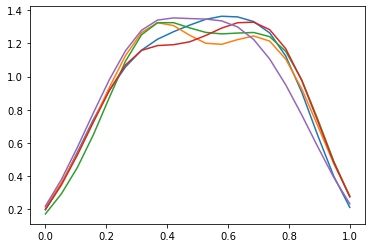

In [424]:
ex = kde_df.loc[kde_df['dist']=='trapezoid_0.3_0.8']
for i in range(5):
    y = ex.iloc[i]
    y = y[0:20]
    x = np.linspace(0,1,20)

    plt.plot(x,y)